# QSPICE Python Files Initialization

In [1]:
import os
import shutil

# Get the current working directory (where your script is running)
current_dir = os.getcwd()

# Define the source folder (QSPICE_Parser is located above the project directory)
source_folder = os.path.join(os.path.dirname(current_dir), 'QSPICE_Parser')

# Define the source file path
source_file = os.path.join(source_folder, 'QSPICE_parser.py')

# Define the destination folder within the project (subfolder called QSPICE)
destination_folder = os.path.join(current_dir, 'QSPICE')

# Define the destination file path (within the QSPICE subfolder)
destination_file = os.path.join(destination_folder, 'QSPICE_parser.py')

# Copy the file from source to destination
shutil.copy(source_file, destination_file)

'c:\\Users\\Stani\\OneDrive\\JupyterLab\\GitHub\\PowerElectronics_JupyterLab_QSPICE\\CCM_Boost_PFC\\QSPICE\\QSPICE_parser.py'

In [2]:
from QSPICE import QSPICE_parser
import importlib
import sys

# reload QSPICE/Python parser without kernel restart
importlib.reload(QSPICE_parser)

#Create PyQSPICE file for input rectifier
QSPICE_parser.parse_and_generate_script('CCM_Boost_PFC_AMC.qsch','QSPICE_CCM_Boost_PFC_AMC.py')

# Delete parser script file from QSPICE folder
os.remove(destination_file)

In [54]:
import math
import pandas as pd
import numpy as np

%matplotlib ipympl
#load all QSPICE autogenerating scripts here
from QSPICE import QSPICE_CCM_Boost_PFC_AMC as QSPICE

from IPython.display import display, Markdown, Latex
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

plt.close('all')
pd.options.display.float_format = '{:.5e}'.format

# Reload QSPICE autogenerating circuit script without kernel restart
importlib.reload(QSPICE)

# 2D interpolation 
# path - path to data folder
# file_name - filename of csv file with EON/EFF data
# VDS - MOSFET VDS value
# ID - drain current
# note: current vector has to start from 0 up to value larger than maximum peak current
# note: voltage vector should start from 0 up to VDS_max
def ESW_Interp(path,file_name,VDS,ID):
    
    ESW=0
    if (VDS >= 0) and (file_name != ''):
        df = pd.read_csv(path+file_name, header=None)

        Y=df.iloc[1:len(df.index),0].to_numpy()

        X=df.iloc[0,1:].to_numpy()

        data=df.iloc[1:,1:].to_numpy()
   
        interp = RegularGridInterpolator((Y,X),data)
        ESW=interp((ID,VDS))
       
    else:
        ESW=0
    
    
    return ESW

# Switching Losses Calculation
# data - Pandas dataframe
# VDS - VDS value. In Boost PFC, VDS is equal to Vout

#return: Total energy in J over current waveform period
def ESW_Calc(data,VDS):
    
    #df = pd.read_csv(path+file_name)
    df = data
    # Modify the data so small numerical deviation from 0 and 1 will not interfere with TurnON/OFF detection
    # Tolerance range for modification. E.g. Value within range of 1 +/- tolerance is still concidered as 1
    tolerance=1e-4
    df['v(pwm)']=df['v(pwm)'].apply(lambda x: 1 if (1-tolerance) <= x <= (1+tolerance) else x)
    df['v(pwm)']=df['v(pwm)'].apply(lambda x: 0 if (0-tolerance) <= x <= (0+tolerance) else x)

    #Detect Turn-OFF (1->0)
    mask_OFF = (df['v(pwm)'] == 1) & (df['v(pwm)'].shift(-1) < 1)
    
    #Detect Turn-ON (0->1)
    mask_ON = (df['v(pwm)'] == 1) & (df['v(pwm)'].shift(1) < 1)

    # DataFrame of currents for Turn-OFF energy calculation
    I_OFF = df.loc[mask_OFF,['time','i(s1)']]
    # Replace all negative current values by 0
    I_OFF['i(s1)'] = I_OFF['i(s1)'].apply(lambda x: max(0,x))
    
    # DataFrame of currents for Turn-ON energy calculation
    I_ON = df.loc[mask_ON,['time','i(s1)']]
    # Replace all negative current values by 0
    I_ON['i(s1)'] = I_ON['i(s1)'].apply(lambda x: max(0,x))

    # Calculate and add EOFF column
    I_OFF['EOFF'] = ESW_Interp(MOS_DATA_FLD,EOFF_file_name,VDS,I_OFF['i(s1)'])

    # Calculate and add EON column
    I_ON['EON'] = ESW_Interp(MOS_DATA_FLD,EON_file_name,VDS,I_ON['i(s1)'])

    sum_EOFF = I_OFF['EOFF'].sum()
    sum_EON = I_ON['EON'].sum()
    E_tot = sum_EOFF + sum_EON

    #   print(I_OFF.to_string())
    #   print(I_ON.to_string())

    #   print('Total Eoff = ', sum_EOFF)
    #   print('Total Eon = ', sum_EON)
    #   print('Total ESW = ', E_tot)

    return [E_tot, I_OFF, I_ON]

def resample(data_x, data_y, fsw):

    """
    Resample data so they are evenly distributed.

    Parameters:
        data_x (float): X data
        data_y (float): Y data
        fsw (float): Fundamental frequency
        
    Returns:
        (x_even, waveform_resampled, sampling_rate): Returns the same resampled data and its sampling rate

    """
    duration = data_x.max() - data_x.min() # Duration of the signal in seconds
    f_max = 10*fsw # the first 10 harmonics are important
    f_sample_min = 10*2*f_max #calc. minimum samplig frequency
    Ts_max = 1/f_sample_min
    num_samples = int(duration / Ts_max)
    x_even = np.linspace(data_x.min(), data_x.max(), num_samples)  # Evenly spaced time samples

    Ts = duration/len(x_even) #calc. sampling period
    sampling_rate = 1/Ts  #calc. sampling rate
        
    # Interpolation 
    interpolator = interp1d(data_x, data_y, kind='linear')  
    waveform_resampled = interpolator(x_even)

    return x_even, waveform_resampled, sampling_rate

def Loop_Compensation(V__g, V__out, Pout, eff, f__sw, C, r__C, L, f__AC):
    V__se = 5 #modulator amplitude
    R__l = 1000 #I_E/A input resistor (pre-selected)
    f__z = f__sw/15
    f__c = f__sw/10 #I-loop cross-over freq.
    f__p = f__sw/1.5
    R__i = 1 / (math.sqrt(2) * Pout * (1 + (-math.sqrt(2) * V__g ** 3 + V__g ** 2 * V__out) / L / Pout / V__out / f__sw / 2) / eff / V__g) #V/A ratio

    R__L = V__out ** 2 / Pout * eff
    D = -V__g / V__out + 1
    gain_Iloop = (
        abs(-1 + D) ** 2
        / abs(
            V__out
            * (1 + complex(0, 2) * math.pi * f__c * C * (R__L / 2 + r__C))
            * R__i
            / V__se
            / R__L
            / (
                -4 * math.pi**2 * f__c**2 * L * C * (R__L + r__C) / R__L / (1 - D) ** 2
                + complex(0, 2)
                * (L + C * (1 - D) ** 2 * R__L * r__C)
                * math.pi
                * f__c
                * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2) ** (-0.1e1 / 0.2e1)
                * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C)) ** (-0.1e1 / 0.2e1)
                + 1
            )
        )
        / 2
    )
    # E/A current loop compensator component values
    R__f = R__l*gain_Iloop
    C__fz = 0.1e1 / R__l / gain_Iloop / math.pi / f__z / 2
    C__fp = C__fz / (2 * C__fz * R__f * math.pi * f__p - 1)

    #Saving E/A current loop compensator component values
    Rf_I = R__f
    Cfp_I = C__fp
    Cfz_I = C__fz

    R__l = 10000 #V_E/A input resistor (manually selected)
    f__z = 0.1e1 / C / R__L / math.pi
    f__c = f__AC/2 #Outer-loop cross-over freq.
    f__p = f__AC
    beta = 2.5/V__out
    K__BO = 1.5/(math.sqrt(2)*V__g)

    gain_outer_loop = math.pi / abs(
        beta
        * (1 + complex(0, 0.15e2 / 0.2e1) * f__AC / f__sw)
        * V__out
        * (complex(0, 1) * math.pi * f__AC * C * r__C + 1)
        * (1 + complex(0, -1) * math.pi * f__AC * L / (1 - D) ** 2 / R__L)
        * V__g
        * K__BO
        / R__l
        / (
            0.5305164770e0
            * abs(
                V__out
                * (
                    1
                    + complex(0, 0.1e1 / 0.5e1)
                    * math.pi
                    * f__sw
                    * C
                    * (R__L / 2 + r__C)
                )
                * R__i
                / V__se
                / R__L
                / (
                    -(math.pi**2)
                    * f__sw**2
                    * L
                    * C
                    * (R__L + r__C)
                    / (1 - D) ** 2
                    / R__L
                    / 25
                    + complex(0, 0.1e1 / 0.5e1)
                    * (L + C * (1 - D) ** 2 * R__L * r__C)
                    * math.pi
                    * f__sw
                    * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2) ** (-0.1e1 / 0.2e1)
                    * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C)) ** (-0.1e1 / 0.2e1)
                    + 1
                )
            )
            / R__l
            / abs(-1 + D) ** 2
            / f__sw
            + 15
            * abs(
                V__out
                * (
                    1
                    + complex(0, 0.1e1 / 0.5e1)
                    * math.pi
                    * f__sw
                    * C
                    * (R__L / 2 + r__C)
                )
                * R__i
                / V__se
                / R__L
                / (
                    -(math.pi**2)
                    * f__sw**2
                    * L
                    * C
                    * (R__L + r__C)
                    / (1 - D) ** 2
                    / R__L
                    / 25
                    + complex(0, 0.1e1 / 0.5e1)
                    * (L + C * (1 - D) ** 2 * R__L * r__C)
                    * math.pi
                    * f__sw
                    * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2) ** (-0.1e1 / 0.2e1)
                    * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C)) ** (-0.1e1 / 0.2e1)
                    + 1
                )
            )
            / R__l
            / abs(-1 + D) ** 2
            / math.pi
            / f__sw
        )
        / f__AC
        / (
            1
            + complex(0, 0.3978873579e1)
            * f__AC
            * abs(
                V__out
                * (
                    1
                    + complex(0, 0.1e1 / 0.5e1)
                    * math.pi
                    * f__sw
                    * C
                    * (R__L / 2 + r__C)
                )
                * R__i
                / V__se
                / R__L
                / (
                    -(math.pi**2)
                    * f__sw**2
                    * L
                    * C
                    * (R__L + r__C)
                    / (1 - D) ** 2
                    / R__L
                    / 25
                    + complex(0, 0.1e1 / 0.5e1)
                    * (L + C * (1 - D) ** 2 * R__L * r__C)
                    * math.pi
                    * f__sw
                    * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2) ** (-0.1e1 / 0.2e1)
                    * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C)) ** (-0.1e1 / 0.2e1)
                    + 1
                )
            )
            / (
                0.5305164770e0
                * abs(
                    V__out
                    * (
                        1
                        + complex(0, 0.1e1 / 0.5e1)
                        * math.pi
                        * f__sw
                        * C
                        * (R__L / 2 + r__C)
                    )
                    * R__i
                    / V__se
                    / R__L
                    / (
                        -(math.pi**2)
                        * f__sw**2
                        * L
                        * C
                        * (R__L + r__C)
                        / (1 - D) ** 2
                        / R__L
                        / 25
                        + complex(0, 0.1e1 / 0.5e1)
                        * (L + C * (1 - D) ** 2 * R__L * r__C)
                        * math.pi
                        * f__sw
                        * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2)
                        ** (-0.1e1 / 0.2e1)
                        * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C))
                        ** (-0.1e1 / 0.2e1)
                        + 1
                    )
                )
                / R__l
                / abs(-1 + D) ** 2
                / f__sw
                + 15
                * abs(
                    V__out
                    * (
                        1
                        + complex(0, 0.1e1 / 0.5e1)
                        * math.pi
                        * f__sw
                        * C
                        * (R__L / 2 + r__C)
                    )
                    * R__i
                    / V__se
                    / R__L
                    / (
                        -(math.pi**2)
                        * f__sw**2
                        * L
                        * C
                        * (R__L + r__C)
                        / (1 - D) ** 2
                        / R__L
                        / 25
                        + complex(0, 0.1e1 / 0.5e1)
                        * (L + C * (1 - D) ** 2 * R__L * r__C)
                        * math.pi
                        * f__sw
                        * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2)
                        ** (-0.1e1 / 0.2e1)
                        * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C))
                        ** (-0.1e1 / 0.2e1)
                        + 1
                    )
                )
                / R__l
                / abs(-1 + D) ** 2
                / math.pi
                / f__sw
            )
            / R__l
            / abs(-1 + D) ** 2
            / f__sw**2
        )
        / V__se
        / (-1 + D)
        / (
            -(math.pi**2) * f__AC**2 * L * C * (R__L + r__C) / (1 - D) ** 2 / R__L
            + complex(0, 1)
            * (L + C * (1 - D) ** 2 * R__L * r__C)
            * math.pi
            * f__AC
            * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2) ** (-0.1e1 / 0.2e1)
            * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C)) ** (-0.1e1 / 0.2e1)
            + 1
        )
        / (
            1
            + complex(0, -2)
            * V__out
            * (1 + complex(0, 1) * math.pi * f__AC * C * (R__L / 2 + r__C))
            * R__i
            * (1 + complex(0, 0.15e2 / 0.2e1) * f__AC / f__sw)
            / V__se
            / (1 - D) ** 2
            / R__L
            / (
                -(math.pi**2) * f__AC**2 * L * C * (R__L + r__C) / (1 - D) ** 2 / R__L
                + complex(0, 1)
                * (L + C * (1 - D) ** 2 * R__L * r__C)
                * math.pi
                * f__AC
                * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2) ** (-0.1e1 / 0.2e1)
                * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C)) ** (-0.1e1 / 0.2e1)
                + 1
            )
            / R__l
            / (
                0.5305164770e0
                * abs(
                    V__out
                    * (
                        1
                        + complex(0, 0.1e1 / 0.5e1)
                        * math.pi
                        * f__sw
                        * C
                        * (R__L / 2 + r__C)
                    )
                    * R__i
                    / V__se
                    / R__L
                    / (
                        -(math.pi**2)
                        * f__sw**2
                        * L
                        * C
                        * (R__L + r__C)
                        / (1 - D) ** 2
                        / R__L
                        / 25
                        + complex(0, 0.1e1 / 0.5e1)
                        * (L + C * (1 - D) ** 2 * R__L * r__C)
                        * math.pi
                        * f__sw
                        * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2)
                        ** (-0.1e1 / 0.2e1)
                        * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C))
                        ** (-0.1e1 / 0.2e1)
                        + 1
                    )
                )
                / R__l
                / abs(-1 + D) ** 2
                / f__sw
                + 15
                * abs(
                    V__out
                    * (
                        1
                        + complex(0, 0.1e1 / 0.5e1)
                        * math.pi
                        * f__sw
                        * C
                        * (R__L / 2 + r__C)
                    )
                    * R__i
                    / V__se
                    / R__L
                    / (
                        -(math.pi**2)
                        * f__sw**2
                        * L
                        * C
                        * (R__L + r__C)
                        / (1 - D) ** 2
                        / R__L
                        / 25
                        + complex(0, 0.1e1 / 0.5e1)
                        * (L + C * (1 - D) ** 2 * R__L * r__C)
                        * math.pi
                        * f__sw
                        * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2)
                        ** (-0.1e1 / 0.2e1)
                        * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C))
                        ** (-0.1e1 / 0.2e1)
                        + 1
                    )
                )
                / R__l
                / abs(-1 + D) ** 2
                / math.pi
                / f__sw
            )
            / math.pi
            / f__AC
            / (
                1
                + complex(0, 0.3978873579e1)
                * f__AC
                * abs(
                    V__out
                    * (
                        1
                        + complex(0, 0.1e1 / 0.5e1)
                        * math.pi
                        * f__sw
                        * C
                        * (R__L / 2 + r__C)
                    )
                    * R__i
                    / V__se
                    / R__L
                    / (
                        -(math.pi**2)
                        * f__sw**2
                        * L
                        * C
                        * (R__L + r__C)
                        / (1 - D) ** 2
                        / R__L
                        / 25
                        + complex(0, 0.1e1 / 0.5e1)
                        * (L + C * (1 - D) ** 2 * R__L * r__C)
                        * math.pi
                        * f__sw
                        * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2)
                        ** (-0.1e1 / 0.2e1)
                        * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C))
                        ** (-0.1e1 / 0.2e1)
                        + 1
                    )
                )
                / (
                    0.5305164770e0
                    * abs(
                        V__out
                        * (
                            1
                            + complex(0, 0.1e1 / 0.5e1)
                            * math.pi
                            * f__sw
                            * C
                            * (R__L / 2 + r__C)
                        )
                        * R__i
                        / V__se
                        / R__L
                        / (
                            -(math.pi**2)
                            * f__sw**2
                            * L
                            * C
                            * (R__L + r__C)
                            / (1 - D) ** 2
                            / R__L
                            / 25
                            + complex(0, 0.1e1 / 0.5e1)
                            * (L + C * (1 - D) ** 2 * R__L * r__C)
                            * math.pi
                            * f__sw
                            * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2)
                            ** (-0.1e1 / 0.2e1)
                            * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C))
                            ** (-0.1e1 / 0.2e1)
                            + 1
                        )
                    )
                    / R__l
                    / abs(-1 + D) ** 2
                    / f__sw
                    + 15
                    * abs(
                        V__out
                        * (
                            1
                            + complex(0, 0.1e1 / 0.5e1)
                            * math.pi
                            * f__sw
                            * C
                            * (R__L / 2 + r__C)
                        )
                        * R__i
                        / V__se
                        / R__L
                        / (
                            -(math.pi**2)
                            * f__sw**2
                            * L
                            * C
                            * (R__L + r__C)
                            / (1 - D) ** 2
                            / R__L
                            / 25
                            + complex(0, 0.1e1 / 0.5e1)
                            * (L + C * (1 - D) ** 2 * R__L * r__C)
                            * math.pi
                            * f__sw
                            * (L * C * (R__L + r__C) * R__L * (1 - D) ** 2)
                            ** (-0.1e1 / 0.2e1)
                            * (R__L * (1 - D) ** 2 / L / C / (R__L + r__C))
                            ** (-0.1e1 / 0.2e1)
                            + 1
                        )
                    )
                    / R__l
                    / abs(-1 + D) ** 2
                    / math.pi
                    / f__sw
                )
                / R__l
                / abs(-1 + D) ** 2
                / f__sw**2
            )
        )
    )
    
    R__f = R__l*gain_outer_loop
    C__fz = 0.1e1 / R__l / gain_outer_loop / math.pi / f__z / 2
    C__fp = C__fz / (2 * C__fz * R__f * math.pi * f__p - 1)

    Rf_V = R__f
    Cfp_V = C__fp
    Cfz_V = C__fz

    #return [R__f, C__fz, C__fp]
    return [Rf_V, Cfz_V, Cfp_V, Rf_I, Cfz_I, Cfp_I]


# Input Data

In [4]:
# Use simulation (True/False)
sim_on = True

#AC line RMS voltage (in V)
VAC_min = 195
VAC_max = 265
VAC_nom = 230

#AC line freq. (in Hz)
AC_freq=50

#Output Voltage (in V)
Vout=400
Vout_pp=20

#Output power (in W) 
#note: Concider that output power is DC/DC comverter Pout thus (DC/DC / eff_dc_dc)
Pout=940
#Estimated efficiency (in -)
eff=0.96
#switching frequency (in Hz)
fsw=133e3

#Percentage of Inductor ripple current (e.g. for 25% put 0.25) (in -)
IL_ripple=0.5

### Input REC Bridge Diode@75degC ####
REC_fwd = 1 # Build-in potential (in V)
REC_rdiff = 30e-3 # Differential resistance (in Ohm)

### Input EMI Filter ###
#Additional total resistance formed by EMI components (in Ohm)
#CM_Choke+Relay
R_EMI = 8e-3+0.1

### MOSFET ###
# Set MOSFET Data Folder and EOFF and EON file names. If empty string is provided, EOFF and EON energy estimation is skipped and return 0 J
MOS_DATA_FLD = "Data/MOSFET/IPP60R120P7/"

# Note. EOFF and EON data should be obtained using a standard double-pulse test method using the actual boost diode to involve diode Qc and Qrr (if present) in MOSFET Eon.
EOFF_file_name = "EOFF_15V_100degC_5600mOhm_25ns_IDH08G65C6.csv"
EON_file_name = "EON_15V_100degC_5600mOhm_25ns_IDH08G65C6.csv"

#WC RDSon@100degC (in Ohm)
rdson=0.204

### Output Diode@75degC ###
# Infineon IDH08G65C6
BOOST_fwd=0.69 # Build-in potential (in V)
BOOST_rdiff=76e-3 # Differential resistance (in Ohm)

### PFC Inductor ###
Res_L = 70e-3 # Inductance in H

### Output Capacitor ###
Cout_ESR = 25e-3 # Capacitor ESR in Ohms

### Current sense resistor
Rsense = 10e-3 # Current sense resistance in Ohm

# Minimum Inductor Value Estimation (in uH)
Note: Valid at minimum Vin and full load. To maintain the same ripple at maximum Vin, inductance must be higher

In [5]:
L=1/IL_ripple*(VAC_min**2/Pout)*(1-math.sqrt(2)*VAC_min/Vout)*1/fsw
print(round(L*1e6))

189


# Maximum Allowed Pk-Pk Output Voltage Ripple (in V)
To ensure proper boost functionality, output voltage must be alwasy higher than input voltage

In [6]:
Vout_pp_max=Vout-VAC_max*math.sqrt(2)
print(round(Vout_pp_max,2))
if Vout_pp > Vout_pp_max:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Defined output pk-pk voltage ripple does not ensure proper boost functionality </span></font>'))

25.23


# Output Capacitor Requirements

## Minimum Capacitance (in uF)

In [7]:
Cout=Pout/(2*math.pi*AC_freq*Vout_pp*Vout)
round(Cout*1e6,2)

374.01

# Stress Analysis (Worst-Case Calculation)

## Input RMS Current (in A)

In [8]:
I_IN_RMS = Pout/(VAC_min*eff)
round(I_IN_RMS,1)

5.0

## Current Sense Resistor RMS Current (in A)

In [9]:
I_RSENSE_RMS = I_IN_RMS
round(I_RSENSE_RMS,1)

5.0

## Inductor Peak Current (in A)

In [10]:
IL_peak=math.sqrt(2)*(Pout/eff)/VAC_min*(1+IL_ripple/2)
round(IL_peak,1)

8.9

## Inductor RMS Current (in A)

In [11]:
IL_RMS=(Pout/eff)/VAC_min
round(IL_RMS,2)

5.02

## MOSFET RMS Current (in A)

In [12]:
I_FET_RMS=(Pout/eff)/VAC_min*math.sqrt(1-(8*math.sqrt(2)*VAC_min/(3*math.pi*Vout)))
round(I_FET_RMS,2)

3.23

## BOOST Diode AVG Current (in A)

In [13]:
I_BOOST_AVG = Pout/Vout
round(I_BOOST_AVG,2)

2.35

## BOOST Diode RMS Current (in A)

In [14]:
I_BOOST_RMS = Pout/(VAC_min*eff)*math.sqrt((8*math.sqrt(2)*VAC_min)/(3*math.pi*Vout))
round(I_BOOST_RMS,2)

3.84

## Output Capacitor RMS Current (in A)

In [15]:
I_Cout_RMS=math.sqrt((8*math.sqrt(2)*Pout**2/(3*math.pi*VAC_min*Vout))-Pout**2/Vout**2)
round(I_Cout_RMS,2)

2.84

## Output Capacitor Peak Voltage (in V)

In [16]:
V_Cout_MAX = Vout+Vout_pp/2
round(V_Cout_MAX,2)

410.0

## REC Diode AVG Current / per diode (in A)

In [17]:
I_REC_AVG=1/math.pi*math.sqrt(2)*(Pout/eff)/VAC_min
round(I_REC_AVG,2)

2.26

## REC Diode RMS Current / per diode (in A)

In [18]:
I_REC_RMS = math.sqrt(2)*(Pout/(eff*VAC_min))/2
round(I_REC_RMS,2)

3.55

# Stress Analysis (Worst-Case Simulation)

In [19]:
E_SW_FET = 0
#Loop_Compensation(V__g, V__out, Pout, eff, f__sw, C, r__C, L, f__AC):
loop_comp = (Loop_Compensation(VAC_min, Vout, Pout, eff, fsw, Cout, Cout_ESR, L, AC_freq))
#return [Rf_V, Cfz_V, Cfp_V, Rf_I, Cfz_I, Cfp_I]
Rf_V = loop_comp[0]
Cfz_V = loop_comp[1]
Cfp_V = loop_comp[2]
Rf_I = loop_comp[3]
Cfz_I = loop_comp[4]
Cfp_I = loop_comp[5]

#print(loop_comp[0],Rf_I, Cfz_I, Cfp_I, Rf_V, Cfz_V, Cfp_V )
if sim_on == True:  
    # QSPICE_CCM_Boost_PFC_AMC(Cfp_I, Cfp_V, Cfz_I, Cfz_V, Cout, eff, ESR, freq, fsw, L, Pout, Rf_I, Rf_V, Vin_rms, Vout, export_traces = None):
    results_sim=QSPICE.QSPICE_CCM_Boost_PFC_AMC(Cfp_I,Cfp_V,Cfz_I,Cfz_V,Cout,eff,Cout_ESR,AC_freq,fsw,L,Pout,Rf_I,Rf_V, VAC_min, Vout, "V(pwm),V(out),I(L1),I(S1),I(C1)")
    IL_RMS       = results_sim[1]["I_L_RMS"]
    I_BOOST_RMS  = results_sim[1]["I_Dboost_RMS"]
    IL_peak      = results_sim[1]["I_L_PEAK"]
    I_FET_RMS    = results_sim[1]["I_FET_RMS"]
    I_BOOST_AVG  = results_sim[1]["I_Dboost_AVG"]
    
    I_Cout_RMS   = results_sim[1]["I_Cout_RMS"]
    I_REC_RMS    = results_sim[1]["I_REC_RMS"]
    I_REC_AVG    = results_sim[1]["I_REC_AVG"]
    
    V_Cout_MAX   = results_sim[1]["V_Cout_MAX"]
    I_IN_RMS     = results_sim[1]["I_IN_RMS"]
    I_RSENSE_RMS = results_sim[1]["I_RSENSE_RMS"]
    
    E_SW_FET = ESW_Calc(results_sim[0],Vout)[0]
    I_OFF_SW_FET = ESW_Calc(results_sim[0],Vout)[1] #save SW_I_Off data used for Eoff calc.
    I_ON_SW_FET = ESW_Calc(results_sim[0],Vout)[2] #save SW_I_On data used for Eon calc.

    wfrm = results_sim[0]

## Input RMS Current (in A)

In [20]:
round(I_IN_RMS,1)

5.2

## Current Sense Resistor RMS Current (in A)

In [21]:
round(I_RSENSE_RMS,1)

5.2

## Inductor Peak Current (in A)

In [22]:
round(IL_peak,1)

9.3

## Inductor RMS Current (in A)

In [23]:
round(IL_RMS,2)

5.17

## MOSFET RMS Current (in A)

In [24]:
round(I_FET_RMS,2)

3.31

## BOOST Diode AVG Current (in A)

In [25]:
round(I_BOOST_AVG,2)

2.45

## BOOST Diode RMS Current (in A)

In [26]:
round(I_BOOST_RMS,2)

3.97

## Output Capacitor RMS Current (in A)

In [27]:
round(I_Cout_RMS,2)

3.12

### Output Capacitor Current (FFT Spectrum)

In [74]:
time_uneven = wfrm["time"]  
waveform = wfrm["i(c1)"] 

# Resample data for FFT
time_resampled, waveform_resampled, sampling_rate = resample(wfrm["time"], wfrm["i(c1)"], AC_freq*2)

# Perform FFT
fft_values = rfft(waveform_resampled)
num_samples = len(time_resampled)
freq = rfftfreq(num_samples, d=1/sampling_rate)
norm_amplitude = np.abs(fft_values)/num_samples
norm_amplitude[1:] *= 2 # DC component is not mirrored

# Find index of the fundamental frequency
fundamental_idx = np.argmin(np.abs(freq - AC_freq*2))

# Extract the first 10 harmonics
harmonic_indices = [0] + [fundamental_idx * n for n in range(1, 2)]
harmonic_frequencies = freq[harmonic_indices]
harmonic_magnitudes_rms = np.concatenate(([norm_amplitude[0]], norm_amplitude[harmonic_indices[1:2]] / np.sqrt(2)))

# Create a DataFrame for the results
harmonics_table = pd.DataFrame({
    "Harmonic": ["DC Component"] + [f"{n} (Harmonic)" for n in range(1, 2)],
    "Frequency (Hz)": harmonic_frequencies,
    "Magnitude": harmonic_magnitudes_rms
})

harmonics_table["Unit"] = ["AVG"]+ ["RMS"]

'''fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the spectrum
ax[0].stem(freq, norm_amplitude, basefmt=" ", label="FFT Spectrum")
#axes[0].scatter(harmonic_frequencies, harmonic_magnitudes_rms, color="red", label="Harmonics")
ax[0].set_title("FFT Spectrum (Output Capacitor Current) ")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Magnitude")
ax[0].set_xlim(0, np.max(harmonic_frequencies) + 0.1)  # Limit x-axis to harmonics range
ax[0].grid()

# Create a second plot (for example, a simple sine wave) on the second axis (ax[1])
ax[1].plot(time_uneven, waveform)
ax[1].set_title("Output Capacitor Current")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()
'''

# Display the table in Jupyter Notebook
display(harmonics_table.style.format({"Frequency (Hz)": "{:.3f}", "Magnitude": "{:.4f}"}))

,Harmonic,Frequency (Hz),Magnitude,Unit
0,DC Component,0.000,0.0195,AVG
1,1 (Harmonic),100.000,1.8489,RMS


RuntimeError: python error has been set

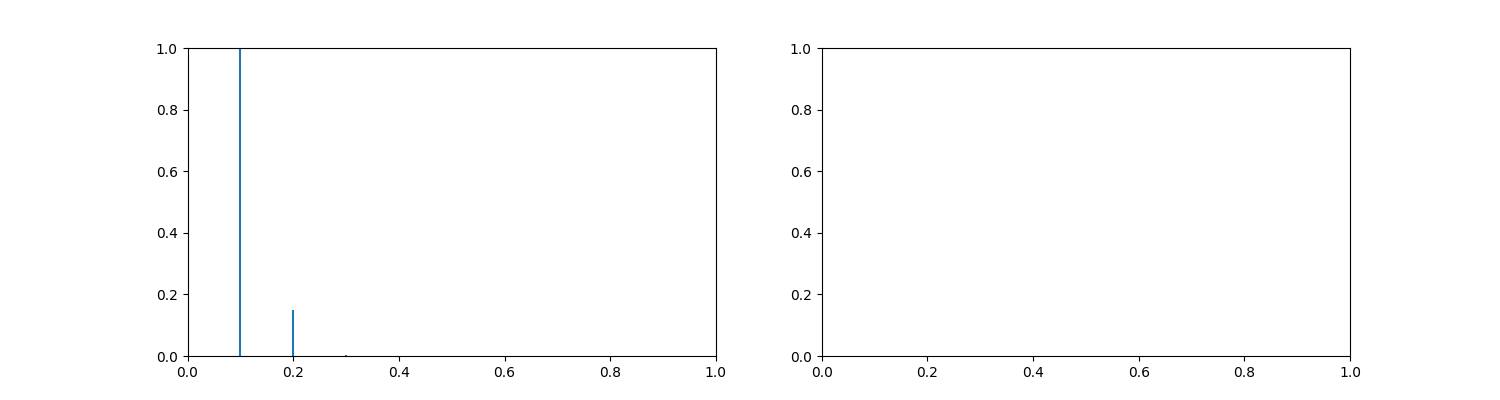

In [75]:
time_uneven = wfrm["time"]  
waveform = wfrm["i(c1)"] 

# Resample data for FFT
time_resampled, waveform_resampled, sampling_rate = resample(wfrm["time"], wfrm["i(c1)"], fsw)

# Perform FFT
fft_values = rfft(waveform_resampled)
num_samples = len(time_resampled)
freq = rfftfreq(num_samples, d=1/sampling_rate)
norm_amplitude = np.abs(fft_values)/num_samples
norm_amplitude[1:] *= 2 # DC component is not mirrored

# Find index of the fundamental frequency
fundamental_idx = np.argmin(np.abs(freq - fsw))

# Extract the first 10 harmonics
harmonic_indices = [0] + [fundamental_idx * n for n in range(1, 11)]
harmonic_frequencies = freq[harmonic_indices]/1000
harmonic_magnitudes_rms = np.concatenate(([norm_amplitude[0]], norm_amplitude[harmonic_indices[1:11]] / np.sqrt(2)))

# Create a DataFrame for the results
harmonics_table = pd.DataFrame({
    "Harmonic": ["DC Component"] + [f"{n} (Harmonic)" for n in range(1, 11)],
    "Frequency (kHz)": harmonic_frequencies,
    "Magnitude": harmonic_magnitudes_rms
})

harmonics_table["Unit"] = ["AVG"]+ ["RMS"] * 10

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the spectrum
ax[0].stem(freq / 1000, norm_amplitude, basefmt=" ", label="FFT Spectrum")
#axes[0].scatter(harmonic_frequencies, harmonic_magnitudes_rms, color="red", label="Harmonics")
ax[0].set_title("FFT Spectrum (Secondary Winding Current) ")
ax[0].set_xlabel("Frequency (kHz)")
ax[0].set_ylabel("Magnitude")
ax[0].set_xlim(0, np.max(harmonic_frequencies) + 0.1)  # Limit x-axis to harmonics range
ax[0].grid()

# Create a second plot (for example, a simple sine wave) on the second axis (ax[1])
ax[1].plot(time_uneven, waveform)
ax[1].set_title("Secondary Winding Current")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

# Display the table in Jupyter Notebook
display(harmonics_table.style.format({"Frequency (kHz)": "{:.3f}", "Magnitude": "{:.4f}"}))

## Output Capacitor Peak Voltage (in V)

In [30]:
round(V_Cout_MAX,2)

410.9

## REC Diode AVG Current / per diode (in A)

In [31]:
round(I_REC_AVG,2)

2.24

## REC Diode RMS Current / per diode (in A)

In [32]:
round(I_REC_RMS,2)

3.66

# Losses Estimation

## Bridge Rectifier (in W)

In [33]:
P_REC=4*(I_REC_AVG*REC_fwd+REC_rdiff*I_REC_RMS**2)

In [34]:
round(P_REC,2)

10.57

## EMI Filter (in W)

In [35]:
P_EMI = R_EMI * I_IN_RMS**2
round(P_EMI,2)

2.89

## Boost Diode

### Conduction Losses (in W)

In [36]:
P_diode_cond=I_BOOST_AVG*BOOST_fwd + BOOST_rdiff * I_BOOST_RMS**2 
round(P_diode_cond,2)

2.89

### Switching Losses (in W)

In [37]:
#P_diode_SW=Vout*BOOST_Qc*fsw
P_diode_SW = 0
round(P_diode_SW,2)

0

This is not losses on diode but on FET which is already included due to DP test performed with actual diode. D_SW has been deleted from graph below. It still remains in total losses calculation but it set to 0. This is true due to the capacitive character of QRR in SiC diode.

## MOSFET

### Conduction Losses (in W)

In [38]:
P_FET_Cond = rdson * I_FET_RMS**2
round(P_FET_Cond,2)

2.24

### Switching Losses (in W)

In [39]:
P_FET_SW = E_SW_FET*AC_freq
float(round(P_FET_SW,2))

2.68

## Output Capacitor (in W)

In [40]:
P_Cout = Cout_ESR * I_Cout_RMS**2
round(P_Cout,2)

0.24

## Current Sense Resistor (in W)

In [41]:
P_Rsense = Rsense*I_RSENSE_RMS**2
round(P_Rsense,2)

0.27

# Estimated Total Converter Losses Without Magnetic Losses

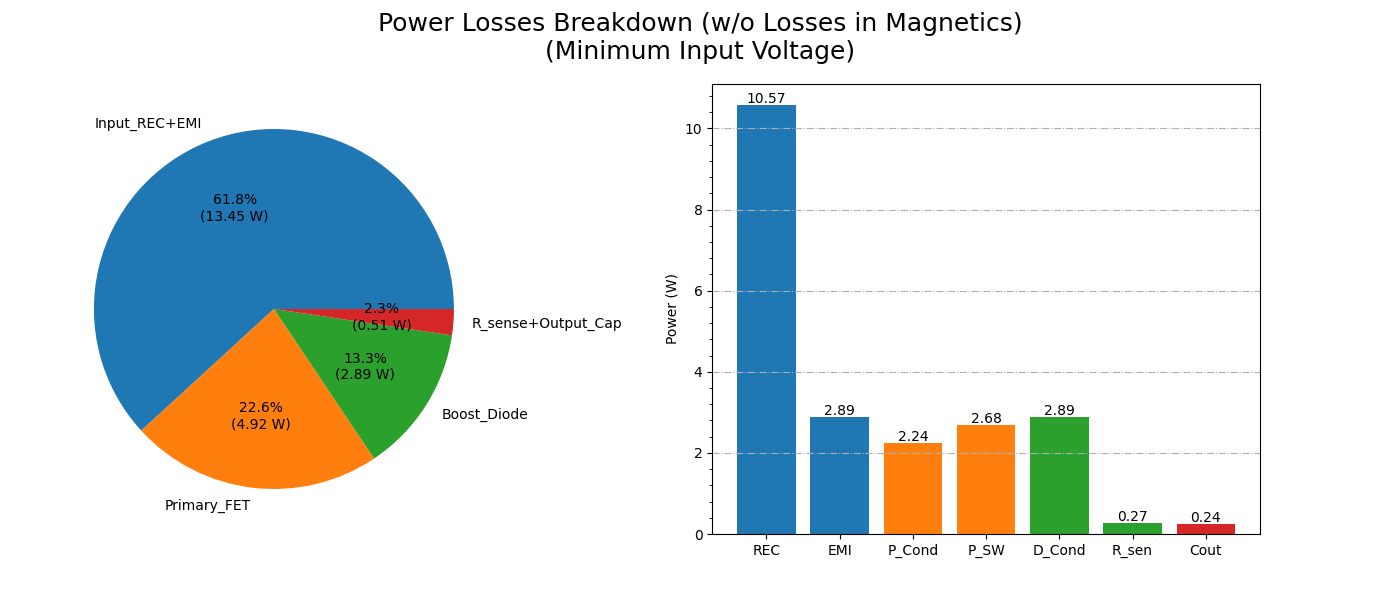

In [42]:
labels_Ploss= 'Input_REC+EMI', 'Primary_FET', 'Boost_Diode', 'R_sense+Output_Cap'
data_Ploss = [P_REC+P_EMI, P_FET_Cond+P_FET_SW, P_diode_cond, P_Rsense+P_Cout]

labels_Ploss_Bar= 'REC', 'EMI', 'P_Cond', 'P_SW', 'D_Cond', 'R_sen', 'Cout'
data_Ploss_Bar = [P_REC, P_EMI, P_FET_Cond, P_FET_SW, P_diode_cond, P_Rsense, P_Cout]

#bar_labels = ['red', 'blue', '_red', 'orange','green']
bar_colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green','tab:red', 'tab:red']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = round(pct*total/100,3)
            return '{:.1f}%\n({v:.2f} W)'.format(pct, v=val)
        return my_format

def addlabels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+0.05, round(y[i],2), ha = 'center')
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
#fig, (ax1, ax2) = plt.subplots(1, 2)
#fig, ax1 = plt.subplots()

if sim_on == True:
    fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics)'+'\n'+'(Minimum Input Voltage)',fontsize=18)
else:
    fig.suptitle('Power Losses Breakdown (w/o MOSFET SW Losses and Losses in Magnetics)'+'\n'+'(Minimum Input Voltage)',fontsize=18)
ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))

ax2.bar(labels_Ploss_Bar, data_Ploss_Bar,color=bar_colors)
ax2.grid(True, linestyle='-.',axis='y')
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_ylabel('Power (W)')
addlabels(labels_Ploss_Bar,data_Ploss_Bar)

fig.subplots_adjust(left = 0, top=0.86, wspace = 0.3)
#fig.subplots_adjust(left=0.05, right=0.95, wspace=0.2)

plt.show()
if sim_on == False:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Primary MOSFET switching losses are available only when simulated.</span></font>'))

# Estimated Total Efficiency Without Magnetics (in %)

In [43]:
P_total = P_REC+P_EMI+P_FET_Cond+P_FET_SW+P_diode_cond+P_diode_SW+P_Rsense+P_Cout
eff_Vin_min = Pout / (Pout+P_total)
float(round(eff_Vin_min*100,1))

97.7

In [44]:
if eff > eff_Vin_min:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: User estimated efficiency is bigger than calculated. The results are underestimated.</span></font>'))

# Selected Waveforms

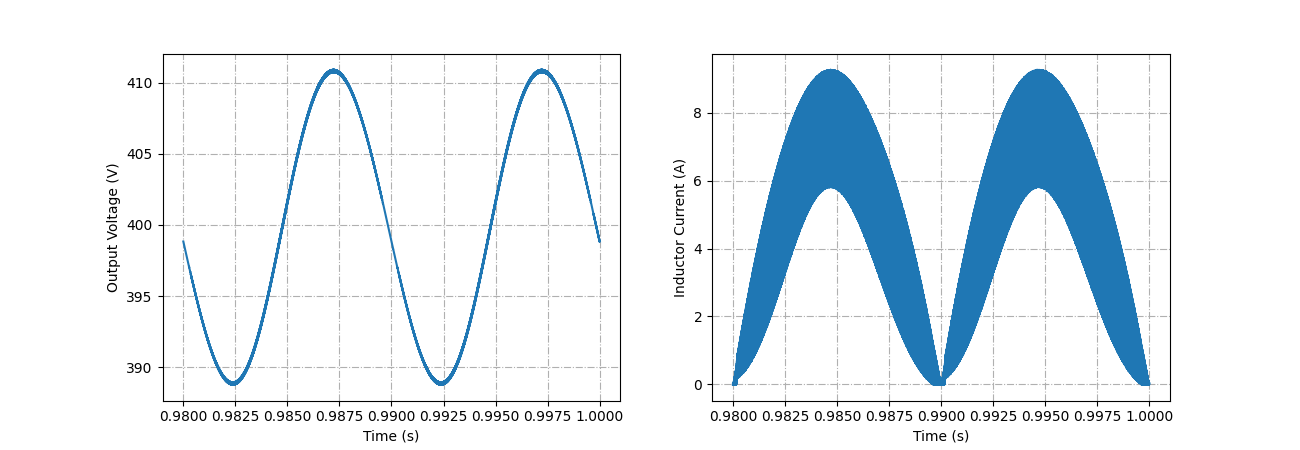

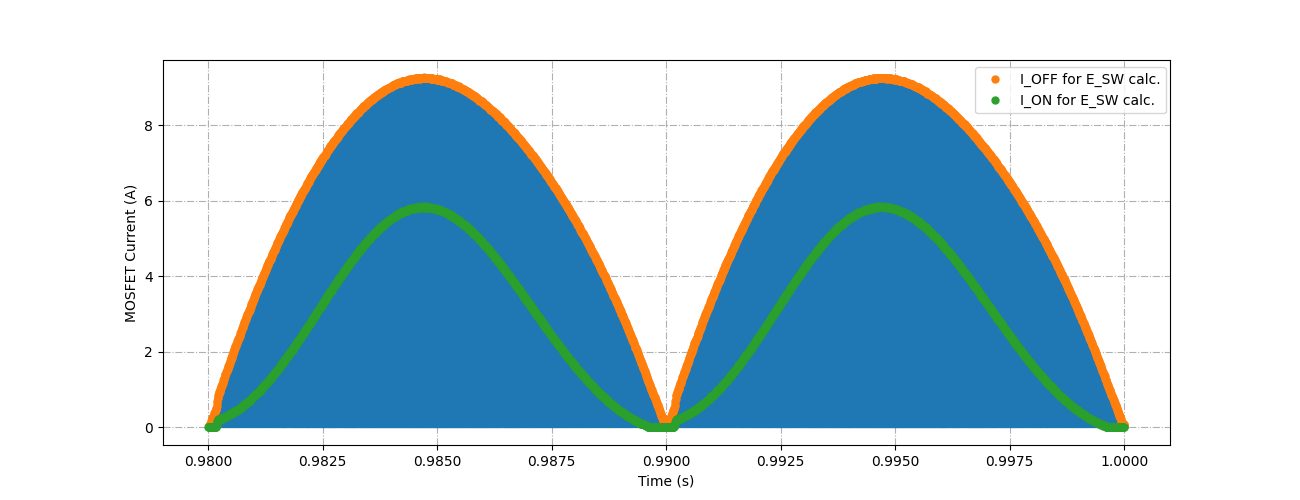

In [45]:
if sim_on == True:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4.5))
    
    #fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics)'+'\n'+'(Minimum Input Voltage)',fontsize=18)
    #ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))
    ax1.plot(wfrm["time"], wfrm["v(out)"])
    ax1.grid(True, linestyle='-.')
    ax1.set(xlabel='Time (s)', ylabel='Output Voltage (V)')
    ax2.plot(wfrm["time"], wfrm["i(l1)"])
    ax2.grid(True, linestyle='-.')
    ax2.set(xlabel='Time (s)', ylabel='Inductor Current (A)')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(13,5))
    #fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics)'+'\n'+'(Minimum Input Voltage)',fontsize=18)
    #ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))
    ax1.plot(wfrm["time"], wfrm["i(s1)"])
    ax1.plot(I_OFF_SW_FET["time"],I_OFF_SW_FET["i(s1)"], 'o', markersize=5, label='I_OFF for E_SW calc.')
    ax1.plot(I_ON_SW_FET["time"],I_ON_SW_FET["i(s1)"], 'o', markersize=5, label='I_ON for E_SW calc.')
    ax1.grid(True, linestyle='-.')
    ax1.set(xlabel='Time (s)', ylabel='MOSFET Current (A)')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1))

    
    plt.show()
    #plt.close()
else:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Available only when simulated.</span></font>'))

# PFC Inductor Design

Based on M. Pieniz, J. R. Pinheiro and H. L. Hey, "An investigation of the boost inductor volume applied to PFC converters," 2006 37th IEEE Power Electronics Specialists Conference, Jeju, Korea (South), 2006, pp. 1-7, doi: 10.1109/pesc.2006.1712248.

It utilized low cost powder core material with a single layer coil


In [46]:
#Maximum wire current density in A/cm^2
j_max = 600

# Minimum wire cross-section in cm^2
S_min = IL_RMS / 600

#Minimum wire diameter in cm
dw_min = math.sqrt(4*S_min/math.pi)

#Minimum wire size in AWG
AWG_min = round(-39*math.log(dw_min*10/0.127,92)+36)
#Core Outside Diameter
OD = 50

## Minimum Wire Diameter

In [47]:
print(S_min*100)
print(dw_min)
#print(AWG)

0.8610283333333333
0.10470412232273422


In [48]:
#N_max = 0.95*math.pi*((OD/(dw*kd))-1)